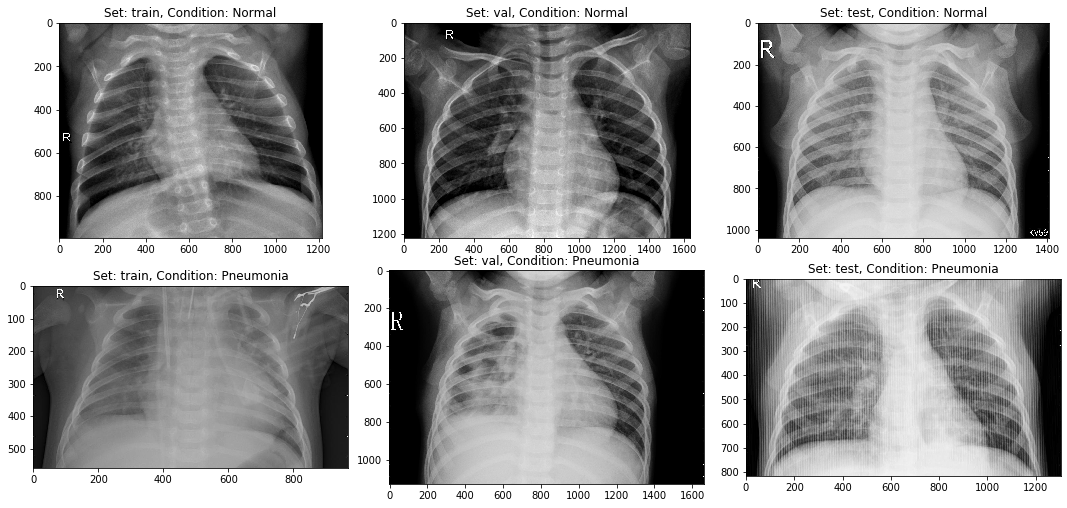

In [1]:

%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline




DATA_DIR = "/home/tiva/Projects/pneumonia_chestxray/chest_xray/"

TRAIN_DIR = DATA_DIR + '/train'                           
TEST_DIR = DATA_DIR + '/test'     
VAL_DIR = DATA_DIR + '/val'

# Let's take a look at our pictures
input_path = DATA_DIR

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))


In [2]:
IMG_SIZE = 300

image_transforms = {
    # Train uses data augmentation
    'train':
    T.Compose([
        T.RandomResizedCrop(size=IMG_SIZE, scale=(0.8, 1.0)),
        T.RandomRotation(degrees=15),
        T.ColorJitter(),
        T.RandomHorizontalFlip(),
        T.CenterCrop(size=224),  # Image net standards
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    T.Compose([
        #T.Grayscale(),
        T.Resize((IMG_SIZE,IMG_SIZE)),
        T.CenterCrop(size=224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    T.Compose([
       # T.Grayscale(),
        T.Resize((IMG_SIZE,IMG_SIZE)),
        T.CenterCrop(size=224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# PyTorch datasets
train_ds = ImageFolder(root=TRAIN_DIR, transform=image_transforms['train'])
valid_ds = ImageFolder(root=VAL_DIR, transform=image_transforms['val'])
test_ds = ImageFolder(root=TEST_DIR, transform=image_transforms['test'])
len(train_ds), len(valid_ds), len(test_ds)


(5216, 16, 624)

In [3]:
print("Classes:")
class_names = train_ds.classes
print(class_names)

Classes:
['NORMAL', 'PNEUMONIA']


In [8]:
import torch
import torch.nn as nn


class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv_layer =nn.Sequential(
            #First convolutional layer    
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            #Second convolutional layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Third convolutional layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(int(128*224*224/64.0), 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        """Perform forward."""        
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x

net = SimpleCNN()
net.cuda()
from torchsummary import summary
print(summary(net, input_size=(3, 224, 224)))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Linear-10                  [-1, 256]      25,690,368
             ReLU-11                  [-1, 256]               0
           Linear-12                    [-1, 1]             257
Total params: 25,783,873
Trainable params: 25,783,873
Non-trainable params: 0
-------------------------

In [9]:
batch_size = 4
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=0, pin_memory=False)

for data in valid_dl:
    images,labels = data
    print (images.shape,labels.shape)
    

torch.Size([4, 3, 224, 224]) torch.Size([4])
torch.Size([4, 3, 224, 224]) torch.Size([4])
torch.Size([4, 3, 224, 224]) torch.Size([4])
torch.Size([4, 3, 224, 224]) torch.Size([4])


In [11]:
import torch.optim as optim

# define Loss Function
criterion = nn.BCEWithLogitsLoss()
# define optimization algorithm
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
from torch.autograd import Variable
import os



"""Define evaluation metric

We will use accuracy as an evaluation metric
"""

def calculate_accuracy(loader):
  total = 0
  correct = 0
  
  with torch.no_grad():
    for data in loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        predicted = (torch.sigmoid(outputs)>=0.5).long()
        predicted = predicted.squeeze()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  return 100 * correct / total   




start_epoch = 0
epochs = 20
for epoch in range(start_epoch, epochs + start_epoch):
    running_loss = 0.0
    net.train()
    for i, data in enumerate(train_dl, 0):
        # get the inputs
        inputs, labels = data   
        inputs = inputs.cuda()
        labels = labels.cuda()
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels.type_as(outputs))
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
    # Normalizing the loss by the total number of train batches
    running_loss /= len(train_dl)
    # Calculate training/val set accuracy of the existing model
    train_accuracy = calculate_accuracy(train_dl)
    net.eval()
    val_accuracy = calculate_accuracy(valid_dl)

    print("Epoch: {0} | Loss: {1} | Training accuracy: {2}% | Validation accuracy: {3}%".format(epoch+1, 
                                                            running_loss, train_accuracy, val_accuracy))


Epoch: 1 | Loss: 0.3364138671354479 | Training accuracy: 89.95398773006134% | Validation accuracy: 62.5%
Epoch: 2 | Loss: 0.25605609816343 | Training accuracy: 92.4463190184049% | Validation accuracy: 68.75%
Epoch: 3 | Loss: 0.2190270328324144 | Training accuracy: 93.19401840490798% | Validation accuracy: 87.5%
Epoch: 4 | Loss: 0.1931356865717899 | Training accuracy: 93.38573619631902% | Validation accuracy: 56.25%
Epoch: 5 | Loss: 0.17596874361954368 | Training accuracy: 92.15874233128834% | Validation accuracy: 56.25%
Epoch: 6 | Loss: 0.16804917485088075 | Training accuracy: 94.15260736196319% | Validation accuracy: 62.5%
Epoch: 7 | Loss: 0.16001466390488436 | Training accuracy: 94.82361963190183% | Validation accuracy: 62.5%
Epoch: 8 | Loss: 0.15104955757038888 | Training accuracy: 95.41794478527608% | Validation accuracy: 62.5%
Epoch: 9 | Loss: 0.1389737472707655 | Training accuracy: 94.6127300613497% | Validation accuracy: 68.75%
Epoch: 10 | Loss: 0.13450925318958096 | Training ac

In [13]:
net.eval()
test_dl = DataLoader(test_ds, 64, num_workers=0, pin_memory=False)
test_accuracy = calculate_accuracy(test_dl)
print ("final test accuracy:", test_accuracy)

final test accuracy: 86.53846153846153
